## Topic Modeling

In [6]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import matplotlib.pyplot as plt
import seaborn as sns


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#the module 'sys' allows istalling module from inside Jupyter
import sys

!{sys.executable} -m pip install numpy
import numpy as np

!{sys.executable} -m pip install pandas
import pandas as pd

#Natrual Language ToolKit (NLTK)
!{sys.executable} -m pip install nltk
import nltk

!{sys.executable} -m pip install sklearn
from sklearn import metrics
#from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import  CountVectorizer #bag-of-words vectorizer 
from sklearn.decomposition import LatentDirichletAllocation #package for LDA


In [ ]:
from pprint import pprint
!{sys.executable} -m pip install pyLDAvis #visualizing LDA
import pyLDAvis
import pyLDAvis.lda_model

In [ ]:
# Plotting tools

import matplotlib.pyplot as plt
%matplotlib inline

#define text normalization function
%run ./Text_Normalization_Function.ipynb #defining text normalization function

#ignore warnings about future changes in functions as they take too much space
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [8]:
#Import data
df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')
df

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


In [12]:
print(df.columns)

Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')


In [13]:
print(df.describe())

         Unnamed: 0   Clothing ID           Age        Rating  \
count  23486.000000  23486.000000  23486.000000  23486.000000   
mean   11742.500000    918.118709     43.198544      4.196032   
std     6779.968547    203.298980     12.279544      1.110031   
min        0.000000      0.000000     18.000000      1.000000   
25%     5871.250000    861.000000     34.000000      4.000000   
50%    11742.500000    936.000000     41.000000      5.000000   
75%    17613.750000   1078.000000     52.000000      5.000000   
max    23485.000000   1205.000000     99.000000      5.000000   

       Recommended IND  Positive Feedback Count  
count     23486.000000             23486.000000  
mean          0.822362                 2.535936  
std           0.382216                 5.702202  
min           0.000000                 0.000000  
25%           1.000000                 0.000000  
50%           1.000000                 1.000000  
75%           1.000000                 3.000000  
max           

In [15]:
# Group by department
grouped = df.groupby('Department Name')

In [14]:
# Create empty dictionary
word_dict = {}

In [16]:
# Preprocess the data: Tokenization, stopwords, stemming
tokenizer = RegexpTokenizer(r'\w+')
en_stopwords = stopwords.words('english')
p_stemmer = PorterStemmer()

In [17]:
# extract the review text and fill the nas
df['Review Text'].fillna('', inplace=True)

In [40]:

def process_text(text):
    raw = str(text).lower()
    tokens = tokenizer.tokenize(raw)
    stopped_tokens = [token for token in tokens if not token in en_stopwords]
    stemmed_tokens = [p_stemmer.stem(token) for token in stopped_tokens]
    return stemmed_tokens

In [41]:
# Train LDA models by department
ldamodels = {}
for name, group in grouped:
    texts = [process_text(text) for text in group['Review Text']]
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    ldamodel = models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=5)
    ldamodels[name] = ldamodel

In [42]:
# Define the function of coherence and perplexity 
def compute_metrics(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    perplexity_values = []
    model_list = []
    for num_topics in range(start, limit+1, step):
        model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=5)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity_values.append(model.log_perplexity(corpus))
    return model_list, coherence_values, perplexity_values

In [43]:
# Find the optimal topic number
from gensim.models.coherencemodel import CoherenceModel
best_num_topics = {}
for name, group in grouped:
    texts = [process_text(text) for text in group['Review Text']]
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    model_list, coherence_values, perplexity_values = compute_metrics(dictionary, corpus, texts, limit=5, step=1)
    best_num_topics[name] = coherence_values.index(max(coherence_values)) + 2

In [44]:
# Print best number of topics for each group
for name, num_topics in best_num_topics.items():
    print(f"Department Name: {name}, Best Number of Topics: {num_topics}")

Department Name: Bottoms, Best Number of Topics: 2
Department Name: Dresses, Best Number of Topics: 3
Department Name: Intimate, Best Number of Topics: 2
Department Name: Jackets, Best Number of Topics: 3
Department Name: Tops, Best Number of Topics: 5
Department Name: Trend, Best Number of Topics: 4


In [45]:
# Train LDA models with the best number of topics for each group
lda_models = {}
for name, group in grouped:
    texts = [process_text(text) for text in group['Review Text']]
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    num_topics = best_num_topics[name]
    lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=5)
    lda_models[name] = lda_model


In [46]:
# Print LDA topics for each group
for name, lda_model in lda_models.items():
    print(f"Department Name: {name}")
    for topic_id, topic in lda_model.print_topics(num_topics=best_num_topics[name]):
        print(f"Topic {topic_id+1}: {topic}")

Department Name: Bottoms
Topic 1: 0.027*"fit" + 0.022*"size" + 0.020*"pant" + 0.018*"love" + 0.017*"jean" + 0.013*"wear" + 0.013*"look" + 0.013*"like" + 0.013*"great" + 0.012*"5"
Topic 2: 0.028*"skirt" + 0.016*"love" + 0.015*"size" + 0.012*"color" + 0.011*"look" + 0.011*"fit" + 0.010*"waist" + 0.010*"fabric" + 0.010*"wear" + 0.009*"small"
Department Name: Dresses
Topic 1: 0.045*"dress" + 0.034*"size" + 0.026*"fit" + 0.025*"5" + 0.016*"small" + 0.015*"order" + 0.015*"petit" + 0.013*"love" + 0.011*"4" + 0.010*"wear"
Topic 2: 0.063*"dress" + 0.020*"love" + 0.020*"look" + 0.014*"fit" + 0.013*"wear" + 0.012*"great" + 0.012*"color" + 0.012*"fabric" + 0.011*"like" + 0.010*"flatter"
Topic 3: 0.040*"dress" + 0.018*"like" + 0.014*"look" + 0.011*"back" + 0.010*"review" + 0.009*"one" + 0.009*"fit" + 0.008*"fabric" + 0.008*"tri" + 0.008*"love"
Department Name: Intimate
Topic 1: 0.019*"fit" + 0.017*"love" + 0.014*"wear" + 0.014*"size" + 0.013*"top" + 0.012*"like" + 0.011*"great" + 0.011*"look" + 0.0

Labels for each topic in each department based on the most frequent words that appear in each topic (generated by ChatGPT and adjusted manually)

**For the department "Bottoms":**

Topic 1: "Fit and Comfortable Jeans and Pants" \
Topic 2: "Skirts in Various Colors and Fabrics"

**For the department "Dresses":**

Topic 1: "Sizing and Fit for Petite Women" \
Topic 2: "Flattering and Comfortable Dresses" \
Topic 3: "Overall Look and Back Design"

**For the department "Intimate":**

Topic 1: "Fit, wearability, and love for tops and dresses" \
Topic 2: "Fitting and Sizing Issues for Suits and Leggings"

**For the department "Jackets":**

Topic 1: "Comfortable and Fitting Jackets" \
Topic 2: "Coats and Vests for Different Occasions" \
Topic 3: "Fitting and Sizing Issues"

**For the department "Tops":**

Topic 1: "Fitting and Sizing Issues for Tops" \
Topic 2: "Versatile and Stylish Tops for Different Occasions" \
Topic 3: "Quality and Design Feedback" \
Topic 4: "Soft and Comfortable Sweaters in Various Colors"


**For the department "Trend":**

Topic 1: fit and fabric \
Topic 2: color and overall appearance \

The insights we can gather from the topics generated by the LDA model are the most probable topics that customers are discussing or interested in regarding each department's products. For example, for the bottoms department, customers are most likely concerned about the fit and size of pants and jeans, while for dresses, customers are interested in the dress size and fit, particularly for petite sizes, as well as the style, color, and fabric that flatters the wearer. For jackets, customers are concerned about the jacket size, fit, and look, particularly how they flatter the wearer, and for tops, customers are interested in the top size and fit, particularly for small sizes, as well as the top style, color, and look, particularly with jeans and overall great wearability. These insights can help the company to better understand what their customers are looking for in their products and make improvements accordingly.  \

They can also offer a wider range of sizes and colors to meet the needs of their customers. Additionally, they can focus on using high-quality materials to improve the overall look and feel of their products. The company can also use the feedback on style and design to create products that are not only functional but also aesthetically pleasing to their customers.

# Sentiment Analysis

## Train-test split and perform VADER

Next, we'd like to perform sentiment analysis on the reviews within each topic to gain insights into how customers feel about specific aspects of the product. For example, within the "Fit and size of pants and jeans" topic for the Bottoms department, we could analyze the sentiment of reviews that mention fit and size to determine if customers generally have positive or negative opinions about these aspects of the product. This information could be used to make improvements to the product design, sizing, or marketing messaging.

In [ ]:
#packages needed

#ignore warnings about future changes in functions as they take too much space
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

#the module 'sys' allows istalling module from inside Jupyter
import sys

!{sys.executable} -m pip install numpy
import numpy as np 

!{sys.executable} -m pip install pandas
import pandas as pd

#Natrual Language ToolKit (NLTK)
!{sys.executable} -m pip install nltk
import nltk

#text normalization function
%run ./Text_Normalization_Function.ipynb

#ignore warnings about future changes in functions as they take too much space
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [97]:
# create polarity based on "Rating" column
def polarity_group(val):
  if val == 1 or val == 2:
    return 'negative'
  elif val == 3:
    return 'netural'
  else:
    return 'positive'

df['polarity'] = df['Rating'].apply(polarity_group)

In [102]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

In [104]:
test_reviews = np.array(test_data['Review Text'])
test_polarity = np.array(test_data['polarity'])

train_reviews = np.array(train_data['Review Text'])
train_polarity = np.array(train_data['polarity'])

In [105]:
normalized_test_reviews = normalize_corpus(test_reviews)
normalized_train_reviews = normalize_corpus(train_reviews)

In [126]:
def try_threshold_for_accuracy(sentiment_scores, threshold_for_pos):
    VADER_binary_polarity = ['positive' if s >= threshold_for_pos else 'negative' for s in list(sentiment_scores)]
    accuracy = metrics.accuracy_score(test_polarity, VADER_binary_polarity)
    return(accuracy) 

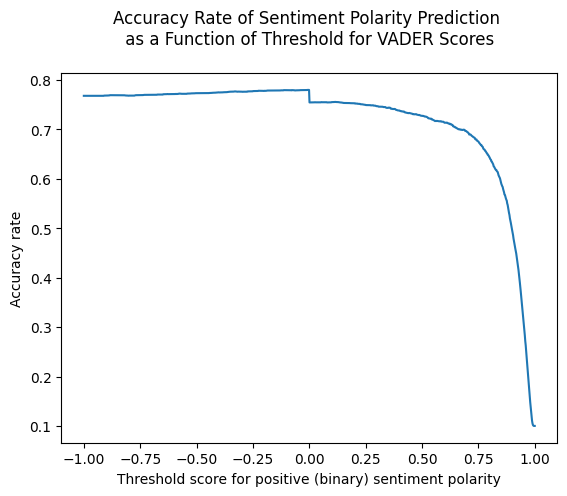

In [127]:
thresholds = np.linspace(-1,1,1000)
acc_rates = [try_threshold_for_accuracy(VADER_polarity_test_df['VADER Score'],threshold) for threshold in thresholds]

plt.plot(thresholds, acc_rates)
plt.xlabel("Threshold score for positive (binary) sentiment polarity")
plt.ylabel("Accuracy rate")
plt.title("Accuracy Rate of Sentiment Polarity Prediction \n as a Function of Threshold for VADER Scores \n")
plt.show()

In [131]:
optimal_threshold = thresholds[acc_rates.index(max(acc_rates))]
optimal_threshold

-0.009009009009009028

In [130]:
#accuracy rate at optimized threshold
max(acc_rates) 

0.779906343124734

In [106]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment_vader_lexicon(review, threshold = 0.1, verbose = False):
    scores = analyzer.polarity_scores(review)  
    binary_sentiment = 'positive' if scores['compound'] >= threshold else 'negative'
    if verbose:                             
        print('VADER Polarity (Binary):', binary_sentiment)
        print('VADER Score:', round(scores['compound'], 2))
    return binary_sentiment,scores['compound']  

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Let's score now all costumer reviews in the test dataset:

(We are adjusting threshold. It was optimal_threshold = -0.009. We are gradually lowering it to reduce false negatives)

In [153]:
VADER_polarity_test = [analyze_sentiment_vader_lexicon(review, threshold= optimal_threshold) for review in test_reviews]
VADER_polarity_test_df = pd.DataFrame(VADER_polarity_test, columns = ['VADER Polarity','VADER Score'])
VADER_polarity_test_df.head()

,VADER Polarity,VADER Score
0,positive,0.9175
1,positive,0.7046
2,positive,0.8588
3,positive,0.7804
4,positive,0.9873


By examining the VADER analysis output, we can get an overall understanding of the sentiment polarity and strength of the reviews, and use that information to draw insights about people's attitudes towards women's clothing. For example, if the majority of the reviews have a positive sentiment polarity and high VADER scores, we can infer that people generally have a positive attitude towards women's clothing. Conversely, if the majority of the reviews have a negative sentiment polarity and low VADER scores, we can infer that people generally have a negative attitude towards women's clothing.

Note that A positive score indicates positive sentiment, a negative score indicates negative sentiment, and a score around 0 indicates neutral sentiment. 

## VADER Model Evaluation

In [154]:
from sklearn import metrics
print('Accuracy Rate:', np.round(metrics.accuracy_score(test_polarity, 
                                VADER_polarity_test_df['VADER Polarity']), 3),"\n")

Accuracy Rate: 0.78 



In [155]:
pd.crosstab(pd.Series(test_polarity), 
            pd.Series(VADER_polarity_test_df['VADER Polarity']), 
            rownames = ['True:'], 
            colnames = ['Predicted:'], 
            margins = True)

Predicted:,negative,positive,All
True:,,,
negative,123,347,470
netural,86,534,620
positive,67,3541,3608
All,276,4422,4698


Precision = true positives / (true positives + false positives)

Interpretation: what share of reviews identified as positive by the algorithm are truely positive?

Recall (Sensitivity) = true positives / (true positives + false negatives)

Interpretation: what share of truely positive reviews in the data was identified as positive by the algorithm?

In [135]:
precision = 3541/4422
print("The precision for this VADER lexicon-based sentiment analysis tool is "+ str(precision))

The precision for this VADER lexicon-based sentiment analysis tool is 0.8007688828584351


In [136]:
recall = 3541/3608
print("The recall(sensitivity) for this VADER lexicon-based sentiment analysis tool is "+ str(recall))

The recall(sensitivity) for this VADER lexicon-based sentiment analysis tool is 0.981430155210643


Have a look at raw VADER scores assigned to actual positive reviews (we sort the reviews by the VADER score in a decreasing order):

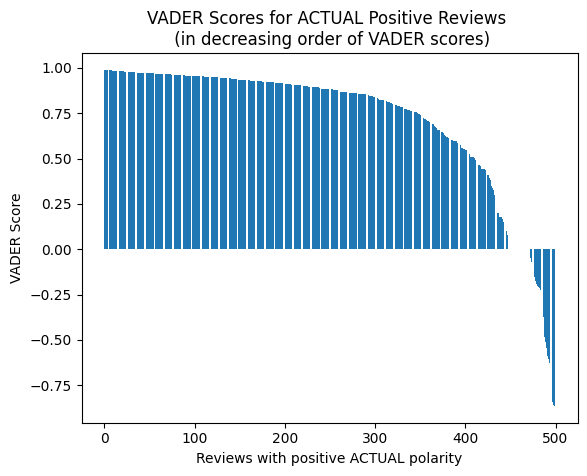

In [156]:
import matplotlib.pyplot as plt

pos_reviews_scored = VADER_polarity_test_df[:500]['VADER Score']
plt.bar(range(0, 500), pos_reviews_scored.sort_values(ascending=False))
plt.xlabel("Reviews with positive ACTUAL polarity")
plt.ylabel("VADER Score")
plt.title("VADER Scores for ACTUAL Positive Reviews \n (in decreasing order of VADER scores)")
plt.show()

Now, have a look at VADER scores assigned to actual negative reviews (we sort the reviews by the VADER score in a decreasing order):



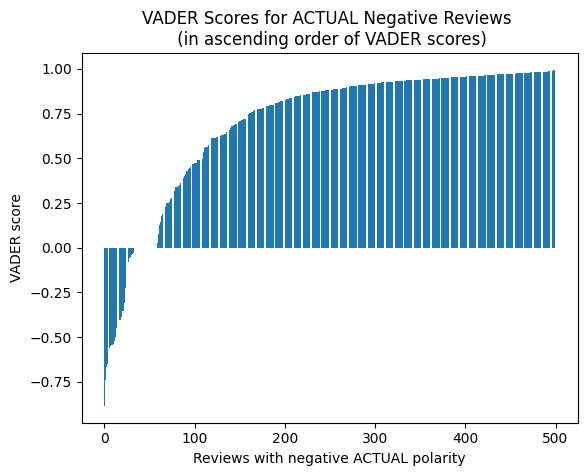

In [157]:
neg_reviews_scored = VADER_polarity_test_df[500:1000]['VADER Score']
plt.bar(range(0, 500), neg_reviews_scored.sort_values(ascending=True))
plt.xlabel("Reviews with negative ACTUAL polarity")
plt.ylabel("VADER score")
plt.title("VADER Scores for ACTUAL Negative Reviews \n (in ascending order of VADER scores)")
plt.show()

The precision score is 0.8. Therefore, about 20% (100% - 80%) of reviews identified by VADER as positive (given the threshold score for a positive review is set to 0.1), are actually negative reviews. VADER is pretty effective at picking up positive sentiment as confirmed by the recall rate of 0.98. The plots confirm the above.
But VADER with this setting is not particularly good at correctly identifying negative sentiment. 

To improve the identification of negative sentiments, We'd like to try adjusting the threshold used in the VADER sentiment analysis. Currently we used compound rate(threshold) = -0.009 which returns the optimal accuracy rate for us. A rather lower threshold may help to capture more negative sentiment in the reviews.

## VADER Sentiment Analysis by Department

In [137]:
# create polarity based on "Rating" column
def polarity_group(val):
    if val == 1 or val == 2:
        return 'negative'
    elif val == 3:
        return 'neutral'
    else:
        return 'positive'

df['polarity'] = df['Rating'].apply(polarity_group)

# group the data by department
grouped = df.groupby('Department Name')


In [ ]:

# perform sentiment analysis on each department
sentiments = []
for group_name, group_data in grouped:
    department_reviews = group_data['Review Text'].tolist()
    normalized_reviews = normalize_corpus(department_reviews)
    VADER_polarity = [analyze_sentiment_vader_lexicon(review, threshold=optimal_threshold)[0] for review in normalized_reviews]
    sentiments.append((group_name, VADER_polarity))
# sentiments

In [159]:
# combine the sentiment analysis with topic modeling
sentiments_df = pd.DataFrame(sentiments, columns=['Department Name', 'Sentiment'])
sentiments_df

,Department Name,Sentiment
0,Bottoms,"[positive, positive, positive, positive, posit..."
1,Dresses,"[positive, positive, positive, positive, posit..."
2,Intimate,"[positive, positive, positive, positive, posit..."
3,Jackets,"[positive, positive, positive, positive, posit..."
4,Tops,"[positive, positive, positive, positive, posit..."
5,Trend,"[positive, positive, positive, positive, posit..."


It turned out that almost all the sentiments are positive! This doesn't make much sense. We are using threshold that returns the highest accuracy rate, which is -0.009. The precision rate in that case is 0.8 and recall rate is 0.98. But even after We made the threshold lower, VADER still couldn't capture the negative comments. So our next step is to train our own supervised model and see if the results can be improved. 

## Support Vector Machines (SVM)

To perform SVM, we need a labeled dataset with each comment labeled as positive, negative, or neutral. While the rating may not be equivalent to sentiment, here we still want to use it to create our labeled dataset by mapping ratings to sentiments. 

In [9]:
# extract the review text and fill the nas
df['Review Text'].fillna('', inplace=True)

Consider that our dataset is imbalanced with higher proportion of positive reviews, here we'd like to assign only reviews with rating = 5 as positive comment.

In [10]:
def map_rating_to_sentiment(rating):
    if rating in [5]:
        return 'positive'
    elif rating in [3, 4]:
        return 'neutral'
    elif rating in [1, 2]:
        return 'negative'

df['sentiment'] = df['Rating'].apply(map_rating_to_sentiment)


In [247]:
df.head(5)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,sentiment
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,neutral
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,positive
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,neutral
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,positive
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,positive


In [229]:
model_target = "sentiment"
model_features = df.columns.drop("sentiment")

print("Model Target: ",model_target)
print("Model Features: ",model_features)

Model Target:  sentiment
Model Features:  Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')


In [230]:
# See our target distribution
df[model_target].value_counts(normalize=True)

positive    0.559099
neutral     0.338414
negative    0.102487
Name: sentiment, dtype: float64

(Caution: the code below takes around 15 minutes)

Now, train the supervised linear SVM classification model on our own, and predict the sentiment score for each review using our SVM model. 

In [14]:
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer

# Define the feature vector and the target variable
X = df['Review Text']
y = df['sentiment']

# Convert the text data into numerical vectors using the TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_vec = vectorizer.fit_transform(X)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train_vec, X_test_vec, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

# Train a linear SVM model
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train_vec, y_train)

# Predict the sentiment score for all review texts in the dataset
y_pred = svm.predict(X_vec)

# Add the predicted sentiment score as a new column in the dataframe
df['SentimentScore'] = y_pred


In [15]:
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,sentiment,topic,SentimentScore
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,neutral,"Fit, wearability, and love for tops and dresses",positive
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,positive,Sizing and Fit for Petite Women,positive
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,neutral,Sizing and Fit for Petite Women,neutral
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,positive,Fit and Comfortable Jeans and Pants,positive
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,positive,Fitting and Sizing Issues for Tops,positive


Evaluate the performance of the model using metrics such as accuracy, precision, recall, and F1-score.

In [264]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y, y_pred))
print(confusion_matrix(y, y_pred))

              precision    recall  f1-score   support

    negative       0.81      0.53      0.64      2407
     neutral       0.73      0.66      0.69      7948
    positive       0.82      0.92      0.87     13131

    accuracy                           0.79     23486
   macro avg       0.79      0.71      0.74     23486
weighted avg       0.79      0.79      0.79     23486

[[ 1283   946   178]
 [  247  5270  2431]
 [   46  1010 12075]]


Based on the performance metrics of the SVM model, it appears to be performing reasonably well. The overall accuracy of the model is 0.79, which indicates that the model correctly predicted the sentiment of the review texts 79% of the time.

The precision, recall, and F1-score for each sentiment class are also quite good, with the positive sentiment class having the highest scores for all three metrics. This suggests that the model is better at predicting positive sentiment than negative or neutral sentiment.

However, it's worth noting that the support for the positive sentiment class is much higher than for the other classes. This may indicate that the model is biased towards predicting positive sentiment, which could be a problem if the dataset is not balanced. Additionally, the precision for the negative sentiment class is lower than the other classes, which could indicate that the model is more likely to predict negative sentiment incorrectly. Overall, the model seems to perform reasonably well, but it's important to consider these potential issues and assess whether the model is appropriate for the specific use case.

# Synthesize Our Findings

To make connections between our sentiment analysis and the topics in each department, we can analyze the sentiment of reviews that mention specific keywords or topics related to each department.  \
For example, in the "Bottoms" department, we can analyze the sentiment of reviews that mention "jeans" or "pants" and focus on the topics of "Fit and Comfortable Jeans and Pants" or "Skirts in Various Colors and Fabrics."  \
Similarly, for the "Dresses" department, we can analyze the sentiment of reviews that mention "petite," "flattering," or "comfortable" and focus on the topics of "Sizing and Fit for Petite Women," "Flattering and Comfortable Dresses," or "Overall Look and Back Design."



(For example, if we find that customers are consistently complaining about sizing and fit issues with dresses in the "Dresses" department, we can use this feedback to make adjustments to our sizing charts or provide more detailed product descriptions. Similarly, if customers are consistently praising the comfort and versatility of tops in the "Trend" department, we can use this feedback to highlight these features in our marketing materials or expand our selection of similar products.)

We'd like to compute the average sentiment score for each topic within each department, and compare them to see which topics are most positively or negatively associated with each department. 

In [2]:
# Define topics for each department
bottoms_topics = {
    "Fit and Comfortable Jeans and Pants": ["jeans", "pants", "fit", "comfortable"],
    "Skirts in Various Colors and Fabrics": ["skirts", "colors", "fabrics"]
}

dresses_topics = {
    "Sizing and Fit for Petite Women": ["sizing", "petite women", "fit"],
    "Flattering and Comfortable Dresses": ["flattering", "comfortable", "dresses"],
    "Overall Look and Back Design": ["look", "design", "back"]
}

intimate_topics = {
    "Fit, wearability, and love for tops and dresses": ["fit", "wearability", "love", "tops", "dresses"],
    "Fitting and Sizing Issues for Suits and Leggings": ["fitting", "sizing", "issues", "suits", "leggings"]
}

jackets_topics = {
    "Comfortable and Fitting Jackets": ["comfortable", "fitting", "jackets"],
    "Coats and Vests for Different Occasions": ["coats", "vests", "occasions"],
    "Fitting and Sizing Issues": ["fitting", "sizing", "issues"]
}

tops_topics = {
    "Fitting and Sizing Issues for Tops": ["fitting", "sizing", "issues", "tops"],
    "Versatile and Stylish Tops for Different Occasions": ["versatile", "stylish", "tops", "occasions"],
    "Quality and Design Feedback": ["quality", "design", "feedback"],
    "Soft and Comfortable Sweaters in Various Colors": ["soft", "comfortable", "sweaters", "colors"]
}

trend_topics = {
    "fit and fabric": ["fit", "fabric"],
    "color and overall appearance": ["color", "appearance"]
}


In [3]:
# Define a function to map the reviews to topics for each department
def map_review_to_topic(review, topics):
    topic_scores = {topic: 0 for topic in topics.keys()}
    for word in review.split():
        for topic, keywords in topics.items():
            if word.lower() in keywords:
                topic_scores[topic] += 1
    return max(topic_scores, key=topic_scores.get)


In [4]:
department_topics = {
    "Bottoms": bottoms_topics,
    "Dresses": dresses_topics,
    "Intimate": intimate_topics,
    "Jackets": jackets_topics,
    "Tops": tops_topics,
    "Trend": trend_topics
}

Now that we have mapped each review to its corresponding topic for each department, we can analyze the sentiment of each review and map it to the relevant topic.

In [20]:
# Drop missing values in the "Department Name" column
df = df.dropna(subset=["Department Name"])
df = df.dropna(subset=["Review Text"])
df = df.loc[df["Department Name"] != ""]

# Map reviews to topics for each department and store in a new column
df["topic"] = df.apply(lambda row: map_review_to_topic(row["Review Text"], department_topics[row["Department Name"]]), axis=1)

# Group by department and topic and compute average sentiment score
grouped = df.groupby(["Department Name", "topic"])["SentimentScore"].apply(lambda x: (x == "positive").mean())

# Print the results
print(grouped)


Department Name  topic                                             
Bottoms          Fit and Comfortable Jeans and Pants                   0.663930
                 Skirts in Various Colors and Fabrics                  0.724138
Dresses          Flattering and Comfortable Dresses                    0.728230
                 Overall Look and Back Design                          0.458425
                 Sizing and Fit for Petite Women                       0.596101
Intimate         Fit, wearability, and love for tops and dresses       0.676811
                 Fitting and Sizing Issues for Suits and Leggings      0.619565
Jackets          Coats and Vests for Different Occasions               0.764706
                 Comfortable and Fitting Jackets                       0.677387
                 Fitting and Sizing Issues                             0.550000
Tops             Fitting and Sizing Issues for Tops                    0.600812
                 Quality and Design Feedback        

Based on the average sentiment score predicted by the SVM model, we can draw several business insights. \
For example, we can see that Tops have a high average sentiment score of 0.852632 regarding its "Versatile and Stylish Tops for Different Occasions", indicating that customers are generally satisfied with the style of the tops. However, sentiments related to Quality and Design only scored 0.467758. Hence, we should focus on introducing new tops with versatile and stylish designs to cater to the customers' preferences while improve on its quality. 